<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/BERT/BERTimbau_noticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers

     |████████████████████████████████| 3.1 MB 15.7 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 44.5 MB/s 
     |████████████████████████████████| 3.3 MB 54.6 MB/s 
     |████████████████████████████████| 596 kB 54.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.

     |████████████████████████████████| 804.1 MB 1.6 kB/s 
     |████████████████████████████████| 17.4 MB 123 kB/s 
     |████████████████████████████████| 1.9 MB 57.3 MB/s 
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.8.1, torchaudio==0.8.0 and torchvision==0.9.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.8.1
    torchvision 0.9.1 depends on torch==1.8.1
    torchaudio 0.8.0 depends on torch==1.8.0

To fix this you could try to:
1. loosen the range of package versions you'

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from google.colab import files, drive
import io, os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
import warnings
warnings.filterwarnings('ignore')

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

# Training

import torch.optim as optim

# Evaluation
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score,  f1_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef
import seaborn as sns

In [5]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks
source_folder = './amostra_news_integrada/amostra_' #'/content'
destination_folder = './bertimbau_resp' #'/content'

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [7]:
class BERTimbau_Noticias():

    def __init__(self, tokenizer, max_seq_length=512, 
               bs=8, lr=1e-6, qtd_categorias=10,
               source_folder = './amostra_news_integrada/amostra_', 
               destination_folder = './bertimbau_resp'):
      self.MAX_SEQ_LEN = max_seq_length #limita os artigos em 128 tokens. BERTimbau base é limitado em 512 tokens por texto.
      self.PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
      self.UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
      self.tokenizer = tokenizer
      self.bs = bs
      self.lr = lr
      self.qtd_categorias=qtd_categorias
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.source_folder = source_folder
      self.destination_folder= destination_folder
    

    def montaFields(self):
      '''Define a estrutura do registro que será utilizada para construir os datasets de treinamento, validação e teste. 
        Também faz a ligação entre o tokenizador BERTimbau e as sequências de texto. 
        Esta estrutura será submetida ao tokenizaAmostra.
        Retorna uma lista contendo o label_field, text_field e o fields que é uma lista de tuplas com text e label'''
      # Fields - use_vocab=False  e tokenizer.encode permite que utilizemos os tokens do BERTimbau.
      label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
      text_field = Field(use_vocab=False, tokenize=self.tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                    fix_length=self.MAX_SEQ_LEN, pad_token=self.PAD_INDEX, unk_token=self.UNK_INDEX)
      fields = [('text', text_field),('label', label_field)]
      return [label_field, text_field, fields]

    def tokenizaAmostra(self, source_folder, soTeste=False):
      ''' Constroi os dataset de treino, validação e teste a partir de csv independentes disponibilizados no caminho source_folder e utilizando
          a estrutura de registro definida em fields, transformando a sequência de textos em sequência de tokens.
          Depois monta os BuckIterator de treino, validação e teste conforme definição do tamanho do bach size.
          Retorna uma lista de Iterators: treino, validação e teste.
          '''    
      #Fields
      label_field, text_field, fields = self.montaFields()
      # TabularDataset
      train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                                test='test.csv', format='CSV', fields=fields, skip_header=True)
      # Iterators

      train_iter, valid_iter = None, None
      test_iter = Iterator(test, batch_size=self.bs, device=self.device, train=False, shuffle=False, sort=False)
      if soTeste == False:
        train_iter = BucketIterator(train, batch_size=self.bs, sort_key=lambda x: len(x.text),
                                  device=self.device, train=True, sort=True, sort_within_batch=True)
        valid_iter = BucketIterator(valid, batch_size=self.bs, sort_key=lambda x: len(x.text),
                                  device=self.device, train=True, sort=True, sort_within_batch=True)
      return [train_iter, valid_iter, test_iter]

    def save_checkpoint(self,save_path, model, valid_loss):

      if save_path == None:
          return
      
      state_dict = {'model_state_dict': model.state_dict(),
                    'valid_loss': valid_loss}
      
      torch.save(state_dict, save_path)
      print(f'Model saved to ==> {save_path}')

    def load_checkpoint(self,load_path, model):
      
      if load_path==None:
          return
      
      state_dict = torch.load(load_path, map_location=self.device)
      print(f'Model loaded from <== {load_path}')
      
      model.load_state_dict(state_dict['model_state_dict'])
      return state_dict['valid_loss']


    def save_metrics(self,save_path, train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision):

      if save_path == None:
          return
      
      state_dict = {'train_loss_list': train_loss_list,
                    'valid_loss_list': valid_loss_list,
                    'global_steps_list': global_steps_list,
                    'valid_accuracy' : valid_accuracy,
                    'valid_precision': valid_precision}
      
      torch.save(state_dict, save_path)
      print(f'Model saved to ==> {save_path}')


    def load_metrics(self,load_path):

      if load_path==None:
          return
      
      state_dict = torch.load(load_path, map_location=processo.device)
      #print(f'Model loaded from <== {load_path}')
      
      return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list'], state_dict['valid_accuracy'], state_dict['valid_precision']

    def save_embedding(self,save_path, embedding):

      if save_path == None:
          return
      
      emb_dict = {'_': embedding}
      
      torch.save(emb_dict, save_path)
      print(f'Embedding saved to ==> {save_path}')

    def load_embedding(self,load_path):

      if load_path==None:
          return
      
      emb_dict = torch.load(load_path, map_location=self.device)
      print(f'Embedding loaded from <== {load_path}')
      
      return emb_dict

    def create_directory(self,path, directory):
      try:
        os.makedirs(path + '/' + directory)
      except FileExistsError:
        # directory already exists
        pass
      
    def train(self, model,
          optimizer,
          train_loader ,
          valid_loader ,
          eval_every ,
          file_path ,
          criterion = nn.CrossEntropyLoss(), #nn.BCELoss(),
          num_epochs = 5,
          best_valid_loss = float("Inf")):
    
    
      print('1 - inicializando variávies')
      # initialize running values
      running_loss = 0.0
      valid_running_loss = 0.0
      global_step = 0
      train_loss_list = []
      valid_loss_list = []
      global_steps_list = []
      y_pred, y_true, valid_accuracy, valid_precision = [],[],[],[]
      # training loop
      print('1 - inicializando treinamento')
      model.train() #habilita os valores dos pesos do modelo para treinamento
      for epoch in range(num_epochs):
          X = []  
          for (text, labels), _ in train_loader:
              labels = labels.type(torch.LongTensor)  #carrega as categorias para pytorch         
              labels = labels.to(self.device) # disponibiliza para as GPU
              text = text.type(torch.LongTensor) #carrega os tokens do texto para pytorch        
              text = text.to(self.device) #disponibiliza para as GPU
              output = model(text, labels) #efetua o treinamento no modelo bert carregado
              loss, _ = output #obtem o valor da função loss do texto treinado

              optimizer.zero_grad() #limpa os gradientes do último treino (zera tudo)
              loss.backward() #calcula a derivada da função perda em relação aos parâmetros
              optimizer.step() #atualiza os pesos fazendo com que o otimizador dê um passo com base no gradiente dos parâmetros

              # update running values
              running_loss += loss.item() #acumula o valor da função loss
              global_step += 1
              #X.extend(_.tolist())
              # evaluation step - roda o modelo para o token de validação, obtém o valor da função loss e tira a média para o treinamento e validação.
              if global_step % eval_every == 0:
                  model.eval() # seta as camadas dropout e batch normalization 
                  with torch.no_grad():                    
                    
                      # validation loop
                      for (text,labels), _ in valid_loader:
                          text = text.type(torch.LongTensor)  
                          text = text.to(self.device)
                          labels = labels.type(torch.LongTensor)           
                          labels = labels.to(self.device)
                          
                          output = model(text, labels)
                          loss, saida = output
                          
                          valid_running_loss += loss.item()
                          y_pred.extend(torch.argmax(saida, 1).tolist())  #obtem do pytorch de saída do modelo o valor predito.
                          y_true.extend(labels.tolist()) #obtem do pytorch de teste  valor real.
                          

                      

                  # evaluation
                  average_train_loss = running_loss / eval_every
                  average_valid_loss = valid_running_loss / len(valid_loader)
                  train_loss_list.append(average_train_loss)
                  valid_loss_list.append(average_valid_loss)
                  global_steps_list.append(global_step)
                  valid_accuracy.append(accuracy_score(y_true, y_pred))
                  valid_precision.append(precision_score(y_true, y_pred, average='micro'))

                  # resetting running values
                  running_loss = 0.0                
                  valid_running_loss = 0.0
                  model.train()

                  # print progress
                  print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                        .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                                average_train_loss, average_valid_loss))
                  
                  # checkpoint
                  if best_valid_loss > average_valid_loss:
                      best_valid_loss = average_valid_loss
                      self.save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                      self.save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision)
                      
          #print(X)
          self.save_embedding(file_path + '/' + 'embedd.pt', X)
      self.save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision)
      #save_embedding(file_path + '/' + 'embedd.pt', X)
      print('Finished Training!')

    def calcula_GMean_multiclass(self,revocacao):
      revoc = np.array(revocacao)
      GMean = revoc.prod()**(1.0/len(revoc))
      return GMean 

    def calcula_especificidade(self, matriz_confusao):
      FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
      FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
      VP = np.diag(matriz_confusao)
      VN = matriz_confusao.sum() - (FP + FN + VP)
      FP = FP.astype(float)
      FN = FN.astype(float)
      VP = VP.astype(float)
      VN = VN.astype(float)
      TVN = np.sum(VN)/(np.sum(VN) + np.sum(FP))
      return TVN
    
    def calcula_especificidade_porClasse(self, matriz_confusao):
      FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
      FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
      VP = np.diag(matriz_confusao)
      VN = matriz_confusao.sum() - (FP + FN + VP)
      FP = FP.astype(float)
      FN = FN.astype(float)
      VP = VP.astype(float)
      VN = VN.astype(float)
      TVN = (VN)/(VN + FP)
      return TVN

    def elabora_relatorio_metricas(self, report, matriz_confusao):
      espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
      dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
      dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
      dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
      dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
      dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
      metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
      df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
      df['support'] = df['support'].astype('int')
      return df

    def elabora_relatorio_metricas(self, report, matriz_confusao):
      espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
      dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
      dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
      dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
      dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
      dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
      metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
      df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
      df['support'] = df['support'].astype('int')
      return df

    def evaluate(self, model, test_loader):
      y_pred = []
      y_true = []
      X = []

      #obtem os valores preditos e os valores de teste
      model.eval()
      with torch.no_grad():
          for (text, labels), _ in test_loader:
                  labels = labels.type(torch.LongTensor)  #carrega as classes para uma estrutura pytorch         
                  labels = labels.to(self.device)  #carrega a estrutura pytorch para GPU (se houver, foi testado anteriormente)
                  text = text.type(torch.LongTensor)    #carrega o texto para uma estrutura pytorch
                  text = text.to(self.device)          #carrega a estrutura pytorch para GPU (se houver, foi testado anteriormente)
                  output = model(text, labels)   #submete o texto e a label da classe ao modelo

                  _, output = output
                  y_pred.extend(torch.argmax(output, 1).tolist())  #obtem do pytorch de saída do modelo o valor predito.
                  y_true.extend(labels.tolist()) #obtem do pytorch de teste  valor real.
                  #print(_)
                  X.extend(output.tolist())
      
      return [X, y_true, y_pred]

    def obtemMetricas(self, y_true, y_pred, ):
      n_classe = np.max(y_true)+1 #obtem o número de classes
      dctResultado={}
      dctResultado['acuraccy'] = accuracy_score(y_true, y_pred)
      dctResultado['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
      dctResultado['precision_global'] = precision_score(y_true, y_pred, average='micro')
      dctResultado['precision_local'] = precision_score(y_true, y_pred, average='macro')
      dctResultado['recall_global'] = recall_score(y_true, y_pred, average='micro')
      dctResultado['recall_local'] = recall_score(y_true, y_pred, average='macro')
      dctResultado['f1score_global'] = f1_score(y_true, y_pred, average='micro')
      dctResultado['f1score_local'] = f1_score(y_true, y_pred, average='macro')
      dctResultado['cohen_kappa'] = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
      dctResultado['ccmatheus'] = matthews_corrcoef(y_true, y_pred)
      report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) 
      dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
      dfrep_a = dfrep[:-3].copy()
      return dctResultado, dfrep_a


    
    def imprimeMetricas(self, y_true, y_pred):
      print('Classification Report:')
      n_classe = np.max(y_true)+1 #obtem o número de classes
      report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) #gera o relatório de métricas
      cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe)) #gera a matriz de confusao
      report = elabora_relatorio_metricas(report, cm) #inclui no relatorio a especificidade
      print(report)

      cohen_kappa = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
      ccmatheus = matthews_corrcoef(y_true, y_pred)
      
      print("Acurácia:",accuracy_score(y_true, y_pred))
      print('Acurácia balanceada:',balanced_accuracy_score(y_true, y_pred))
      print('GMean:', calcula_GMean_multiclass(report['recall']))
      print('Cohen Kappa Score:', cohen_kappa)
      print('Coef. Correlacao Matheus:', ccmatheus)
      print('******************************************************************')
      
      
      #ax= plt.subplot()
      #sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
      #ax.set_title('Confusion Matrix')
      #ax.set_xlabel('Predicted Labels')
      #ax.set_ylabel('True Labels')
      return [X, y_true, y_pred, report]

    def reducaoDimensaoTSNE(self, X, n_componentes=2):
      #perplexity = nro de vizinhos próximos.
      tsne = TSNE(n_components=n_componentes,perplexity=20, metric='euclidean', n_iter=1000, random_state=27, verbose=1)
      X_embedded = tsne.fit_transform(X)
      return X_embedded

    
    def imprimeGraficosReducaoDimensaoTSNE(self, X, y_pred):
      X_embedded = self.reducaoDimensaoTSNE(X)
      ax = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)




class BERT(nn.Module):

    def __init__(self, qtd_categories):
        super(BERT, self).__init__()

        options_name = "bert-base-portuguese-cased"
        self.encoder = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',num_labels=qtd_categories )

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        
        return loss, text_fea

# AJUSTE FINO NOS CLASSIFICADORES E EXECUÇÃO DOS EXPERIMENTOS


In [9]:
##bs=8 e lr=1e-6 (bs menores mostram mais vantagens em encontrar melhores mínimos.)
## Otimizador Adam requer lr menores (testei com valores um pouco maior e um pouco menor, os melhores resultados foram para 1e-6

processo = BERTimbau_Noticias(tokenizer = tokenizer,
                              max_seq_length =128,
                              bs=8,
                              lr=1e-06,
                              qtd_categorias=10)

In [ ]:
#%%time
'''id_planilha = 9.4
dataset = 5
n_epoca = 5
gerais=[]
porclasse=[]
for idx in range(0,10):
  seed= 420 + idx*10
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  processo.create_directory(processo.destination_folder,str(id_planilha)+"/"+str(idx))
  file_path = processo.destination_folder + "/"+str(id_planilha)+"/"+str(idx)
  model = BERT(qtd_categories=processo.qtd_categorias).to(processo.device)
  optimizer = optim.Adam(model.parameters(), lr=processo.lr)
  inicio = datetime.now()
  print('Treinando amostra:', idx, 'inicio:', inicio)
  tokens = processo.tokenizaAmostra(processo.source_folder+str(dataset))
  processo.train(model=model, 
      optimizer=optimizer,
      num_epochs=n_epoca,
      train_loader=tokens[0],
      valid_loader=tokens[1],
      eval_every=len(tokens[0]) // 2, #tamanho do dataset de treinamento / 2 (chão)
      file_path=file_path)
  best_model = BERT(qtd_categories=processo.qtd_categorias).to(processo.device)
  processo.load_checkpoint(file_path + '/model.pt', best_model)
  X_saida_teste, y_true, y_pred = processo.evaluate(best_model, tokens[2]) #tokens[2] é o dataset de teste
  dctMetricas, dfPorClasse = processo.obtemMetricas(y_true,y_pred)    
  gerais.append(dctMetricas)
  porclasse.append(dfPorClasse)
  del(model)
  del(best_model)
  print('Duracao:', datetime.now()-inicio)'''

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 0 inicio: 2021-10-23 17:37:30.629422
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9606, Valid Loss: 1.6553
Model saved to ==> ./bertimbau_resp/9.40/model.pt
Model saved to ==> ./bertimbau_resp/9.40/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.1792, Valid Loss: 1.0164
Model saved to ==> ./bertimbau_resp/9.40/model.pt
Model saved to ==> ./bertimbau_resp/9.40/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.40/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8258, Valid Loss: 0.6514
Model saved to ==> ./bertimbau_resp/9.40/model.pt
Model saved to ==> ./bertimbau_resp/9.40/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5368, Valid Loss: 0.5620
Model saved to ==> ./bertimbau_resp/9.40/model.pt
Model saved to ==> ./bertimbau_resp/9.40/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.40/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5057, Valid Loss: 0.4714
Model saved to ==> 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.40/model.pt
Duracao: 1:01:47.339278


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 1 inicio: 2021-10-23 18:39:19.640324
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9329, Valid Loss: 1.7446
Model saved to ==> ./bertimbau_resp/9.41/model.pt
Model saved to ==> ./bertimbau_resp/9.41/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.1066, Valid Loss: 1.2482
Model saved to ==> ./bertimbau_resp/9.41/model.pt
Model saved to ==> ./bertimbau_resp/9.41/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.41/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8030, Valid Loss: 0.6411
Model saved to ==> ./bertimbau_resp/9.41/model.pt
Model saved to ==> ./bertimbau_resp/9.41/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5161, Valid Loss: 0.5610
Model saved to ==> ./bertimbau_resp/9.41/model.pt
Model saved to ==> ./bertimbau_resp/9.41/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.41/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5208, Valid Loss: 0.4814
Model saved to ==> 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.41/model.pt
Duracao: 1:01:46.178167


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 2 inicio: 2021-10-23 19:41:07.448926
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 2.0087, Valid Loss: 1.9163
Model saved to ==> ./bertimbau_resp/9.42/model.pt
Model saved to ==> ./bertimbau_resp/9.42/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.2680, Valid Loss: 1.3507
Model saved to ==> ./bertimbau_resp/9.42/model.pt
Model saved to ==> ./bertimbau_resp/9.42/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.42/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.9199, Valid Loss: 0.6855
Model saved to ==> ./bertimbau_resp/9.42/model.pt
Model saved to ==> ./bertimbau_resp/9.42/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5453, Valid Loss: 0.5744
Model saved to ==> ./bertimbau_resp/9.42/model.pt
Model saved to ==> ./bertimbau_resp/9.42/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.42/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5537, Valid Loss: 0.4873
Model saved to ==> 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.42/model.pt
Duracao: 1:01:50.531129


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 3 inicio: 2021-10-23 20:42:59.584076
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.8766, Valid Loss: 1.6210
Model saved to ==> ./bertimbau_resp/9.43/model.pt
Model saved to ==> ./bertimbau_resp/9.43/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.1127, Valid Loss: 1.0385
Model saved to ==> ./bertimbau_resp/9.43/model.pt
Model saved to ==> ./bertimbau_resp/9.43/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.43/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.7842, Valid Loss: 0.6262
Model saved to ==> ./bertimbau_resp/9.43/model.pt
Model saved to ==> ./bertimbau_resp/9.43/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5149, Valid Loss: 0.5433
Model saved to ==> ./bertimbau_resp/9.43/model.pt
Model saved to ==> ./bertimbau_resp/9.43/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.43/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.4989, Valid Loss: 0.4611
Model saved to ==> 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.43/model.pt
Duracao: 1:01:50.707651


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 4 inicio: 2021-10-23 21:44:51.900089
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9595, Valid Loss: 1.7874
Model saved to ==> ./bertimbau_resp/9.44/model.pt
Model saved to ==> ./bertimbau_resp/9.44/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.1723, Valid Loss: 1.2279
Model saved to ==> ./bertimbau_resp/9.44/model.pt
Model saved to ==> ./bertimbau_resp/9.44/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.44/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8052, Valid Loss: 0.6288
Model saved to ==> ./bertimbau_resp/9.44/model.pt
Model saved to ==> ./bertimbau_resp/9.44/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5206, Valid Loss: 0.5366
Model saved to ==> ./bertimbau_resp/9.44/model.pt
Model saved to ==> ./bertimbau_resp/9.44/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.44/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5118, Valid Loss: 0.4700
Model saved to ==> 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.44/model.pt
Duracao: 1:01:43.695996


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 5 inicio: 2021-10-23 22:46:37.236325
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9787, Valid Loss: 1.6775
Model saved to ==> ./bertimbau_resp/9.45/model.pt
Model saved to ==> ./bertimbau_resp/9.45/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.2165, Valid Loss: 1.0054
Model saved to ==> ./bertimbau_resp/9.45/model.pt
Model saved to ==> ./bertimbau_resp/9.45/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.45/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8363, Valid Loss: 0.6465
Model saved to ==> ./bertimbau_resp/9.45/model.pt
Model saved to ==> ./bertimbau_resp/9.45/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5380, Valid Loss: 0.5534
Model saved to ==> ./bertimbau_resp/9.45/model.pt
Model saved to ==> ./bertimbau_resp/9.45/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.45/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5145, Valid Loss: 0.4629
Model saved to ==> 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.45/model.pt
Duracao: 1:01:47.344928


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 6 inicio: 2021-10-23 23:48:26.187922
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 2.1070, Valid Loss: 2.1009
Model saved to ==> ./bertimbau_resp/9.46/model.pt
Model saved to ==> ./bertimbau_resp/9.46/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.4550, Valid Loss: 1.4855
Model saved to ==> ./bertimbau_resp/9.46/model.pt
Model saved to ==> ./bertimbau_resp/9.46/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.46/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 1.2197, Valid Loss: 0.8048
Model saved to ==> ./bertimbau_resp/9.46/model.pt
Model saved to ==> ./bertimbau_resp/9.46/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.6188, Valid Loss: 0.6330
Model saved to ==> ./bertimbau_resp/9.46/model.pt
Model saved to ==> ./bertimbau_resp/9.46/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.46/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.6245, Valid Loss: 0.5268
Model saved to ==> 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.46/model.pt
Duracao: 1:01:49.858835


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 7 inicio: 2021-10-24 00:50:17.778376
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9368, Valid Loss: 1.8089
Model saved to ==> ./bertimbau_resp/9.47/model.pt
Model saved to ==> ./bertimbau_resp/9.47/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.1746, Valid Loss: 1.3699
Model saved to ==> ./bertimbau_resp/9.47/model.pt
Model saved to ==> ./bertimbau_resp/9.47/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.47/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8426, Valid Loss: 0.6596
Model saved to ==> ./bertimbau_resp/9.47/model.pt
Model saved to ==> ./bertimbau_resp/9.47/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5440, Valid Loss: 0.5696
Model saved to ==> ./bertimbau_resp/9.47/model.pt
Model saved to ==> ./bertimbau_resp/9.47/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.47/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5306, Valid Loss: 0.4711
Model saved to ==> 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.47/model.pt
Duracao: 1:01:55.137059


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 8 inicio: 2021-10-24 01:52:14.558378
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9140, Valid Loss: 1.6806
Model saved to ==> ./bertimbau_resp/9.48/model.pt
Model saved to ==> ./bertimbau_resp/9.48/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.0815, Valid Loss: 1.1650
Model saved to ==> ./bertimbau_resp/9.48/model.pt
Model saved to ==> ./bertimbau_resp/9.48/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.48/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.7998, Valid Loss: 0.6416
Model saved to ==> ./bertimbau_resp/9.48/model.pt
Model saved to ==> ./bertimbau_resp/9.48/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5082, Valid Loss: 0.5648
Model saved to ==> ./bertimbau_resp/9.48/model.pt
Model saved to ==> ./bertimbau_resp/9.48/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.48/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5153, Valid Loss: 0.4648
Model saved to ==> 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.48/model.pt
Duracao: 1:01:52.110553


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 9 inicio: 2021-10-24 02:54:08.272993
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 2.1226, Valid Loss: 2.1101
Model saved to ==> ./bertimbau_resp/9.49/model.pt
Model saved to ==> ./bertimbau_resp/9.49/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.4958, Valid Loss: 1.4559
Model saved to ==> ./bertimbau_resp/9.49/model.pt
Model saved to ==> ./bertimbau_resp/9.49/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.49/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 1.0478, Valid Loss: 0.7560
Model saved to ==> ./bertimbau_resp/9.49/model.pt
Model saved to ==> ./bertimbau_resp/9.49/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.6004, Valid Loss: 0.6243
Model saved to ==> ./bertimbau_resp/9.49/model.pt
Model saved to ==> ./bertimbau_resp/9.49/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.49/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5841, Valid Loss: 0.5066
Model saved to ==> 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.49/model.pt
Duracao: 1:01:50.550404


## Analisando o Treinamento

In [53]:
def obtem_media_metricas_treino(id_planilha:int, qtd_treino:int=10, plota_grafico:bool=True):
  v_train_loss, v_valid_loss, v_global_steps, v_valid_accuracy, v_valid_precision = [],[],[],[],[]
  for idx in range(qtd_treino):
      file_path = processo.destination_folder + "/"+str(id_planilha)+'/'+str(idx)
      train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision = processo.load_metrics(file_path + '/metrics.pt')
      v_train_loss.append(train_loss_list)
      v_valid_loss.append(valid_loss_list) 
      v_global_steps.append(global_steps_list)
      v_valid_accuracy.append(valid_accuracy)
      v_valid_precision.append(valid_precision)
  mean_train_loss = [np.mean(t) for t in v_train_loss]
  mean_valid_loss = [np.mean(v) for v in v_valid_loss]
  mean_global_steps = [np.mean(g) for g in v_global_steps] 
  mean_valid_accuracy = [np.mean(a) for a in v_valid_accuracy] 
  mean_valid_precision = [np.mean(p) for p in v_valid_precision]    
  
  if plota_grafico==True:
    fig, ax =plt.subplots(1,2, figsize=(12, 8), sharex=True)
    sns.lineplot(x = mean_global_steps, y = mean_train_loss,  label = 'Train', legend='full', palette=palette, ax=ax[0])
    sns.lineplot(x = mean_global_steps, y = mean_valid_loss, label = 'Valid', legend='full', palette=palette, ax=ax[0])
    sns.lineplot(x = mean_global_steps, y = mean_valid_accuracy, label = 'Acurácia', legend='full', palette=palette, ax=ax[1])
    sns.lineplot(x = mean_global_steps, y = mean_valid_precision, label = 'Precisão', legend='full', palette=palette, ax=ax[1])
    ax[0].set_title('Média da função de perda para 10 execuções')  
    ax[0].set_title('Média da acurácia e precisão da validação para 10 execuções durante o treinamento' )
    ax[0].set_ylabel('função loss')
    ax[1].set_ylabel('%')
    ax[0].set_xlabel('iterações executadas')
    ax[1].set_xlabel('iterações executadas: dataset validação')
  return [mean_train_loss, mean_valid_loss, mean_global_steps, mean_valid_accuracy, mean_valid_precision]




def analisa_treinamento(id_planilha):
  r, c = 4, 3 #r é a quantidade de linhas e colunas para posições dos gráficos de loss
  fig, ax =plt.subplots(r,c, figsize=(12, 8), sharex=True)
  fig2, ax2 =plt.subplots(r,c, figsize=(12, 8), sharex=True)
  corte, i,j=2, 0,0 # posição do gráfico: muda de linha a cada corte, l é a linha que vai imprimir o gráfico
  for idx  in range(10):
    file_path = processo.destination_folder + "/"+str(id_planilha)+'/'+str(idx)
    train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision = processo.load_metrics(file_path + '/metrics.pt')
    sns.lineplot(x= global_steps_list, y = train_loss_list,  label = 'Train', legend='full', palette=palette, ax=ax[i,j])
    sns.lineplot(x = global_steps_list, y = valid_loss_list, label = 'Valid', legend='full', palette=palette, ax=ax[i,j])
    sns.lineplot(x = global_steps_list, y = valid_accuracy, label = 'Acurácia', legend='full', palette=palette, ax=ax2[i,j])
    sns.lineplot(x = global_steps_list, y = valid_precision, label = 'Precisão', legend='full', palette=palette, ax=ax2[i,j])
    ax[i,j].set_title('Experimento:' + str(idx+1)  )
    ax2[i,j].set_title('Experimento:' + str(idx+1)  )
    ax[i,j].set_ylabel('função loss')
    ax2[i,j].set_ylabel('%')
    #print(valid_loss_list[-1])
    if (idx<corte):
      j+=1
    else:
      corte+=c
      i+=1
      j=0
  ax[r-1,1].set_xlabel('iterações executadas')
  ax2[r-1,1].set_xlabel('iterações executadas: dataset validação')

Pontos a serem considerados (Checklist do Moacir):

1 - O valor da função de custo nos pesos aleatórios faz sentido? <br>
    Ex. num problema de classificação com 10 classes com entropia cruzada  calculada na saída softmax: -ln(0:1) = 2:3026 <br>

2 - Utilize decaimento de taxa de aprendizado <br>

3- Utilizar SGD (+ Momentum) ou Adam <br>

4 - Acompanhe o custo ao longo de épocas, se possível com
conjunto de validação (idealmente não deve ser o teste!)<br>



In [55]:
saida = obtem_media_metricas_treino(id_planilha = 9, plota_grafico=False)


Model loaded from <== ./bertimbau_resp/9/0/metrics.pt
Model loaded from <== ./bertimbau_resp/9/1/metrics.pt
Model loaded from <== ./bertimbau_resp/9/2/metrics.pt
Model loaded from <== ./bertimbau_resp/9/3/metrics.pt
Model loaded from <== ./bertimbau_resp/9/4/metrics.pt
Model loaded from <== ./bertimbau_resp/9/5/metrics.pt
Model loaded from <== ./bertimbau_resp/9/6/metrics.pt
Model loaded from <== ./bertimbau_resp/9/7/metrics.pt
Model loaded from <== ./bertimbau_resp/9/8/metrics.pt
Model loaded from <== ./bertimbau_resp/9/9/metrics.pt


Model loaded from <== ./bertimbau_resp/9/0/metrics.pt
Model loaded from <== ./bertimbau_resp/9/1/metrics.pt
Model loaded from <== ./bertimbau_resp/9/2/metrics.pt
Model loaded from <== ./bertimbau_resp/9/3/metrics.pt
Model loaded from <== ./bertimbau_resp/9/4/metrics.pt
Model loaded from <== ./bertimbau_resp/9/5/metrics.pt
Model loaded from <== ./bertimbau_resp/9/6/metrics.pt
Model loaded from <== ./bertimbau_resp/9/7/metrics.pt
Model loaded from <== ./bertimbau_resp/9/8/metrics.pt
Model loaded from <== ./bertimbau_resp/9/9/metrics.pt
Model loaded from <== ./bertimbau_resp/9/0/metrics.pt
Model loaded from <== ./bertimbau_resp/9/1/metrics.pt
Model loaded from <== ./bertimbau_resp/9/2/metrics.pt
Model loaded from <== ./bertimbau_resp/9/3/metrics.pt
Model loaded from <== ./bertimbau_resp/9/4/metrics.pt
Model loaded from <== ./bertimbau_resp/9/5/metrics.pt
Model loaded from <== ./bertimbau_resp/9/6/metrics.pt
Model loaded from <== ./bertimbau_resp/9/7/metrics.pt
Model loaded from <== ./bert

IndexError: ignored

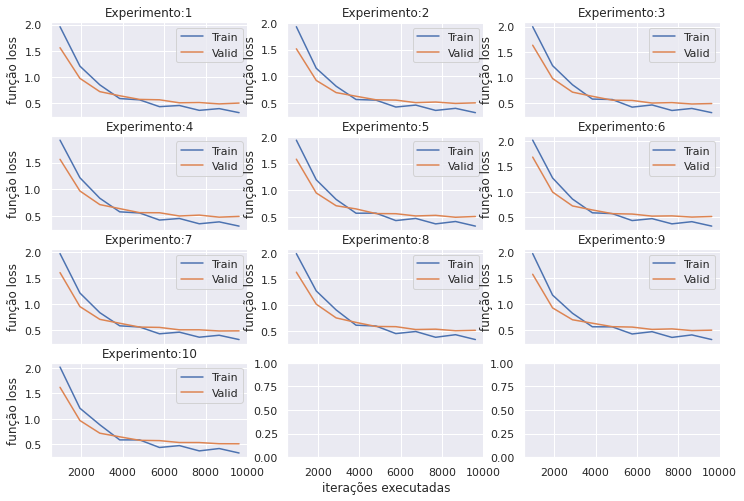

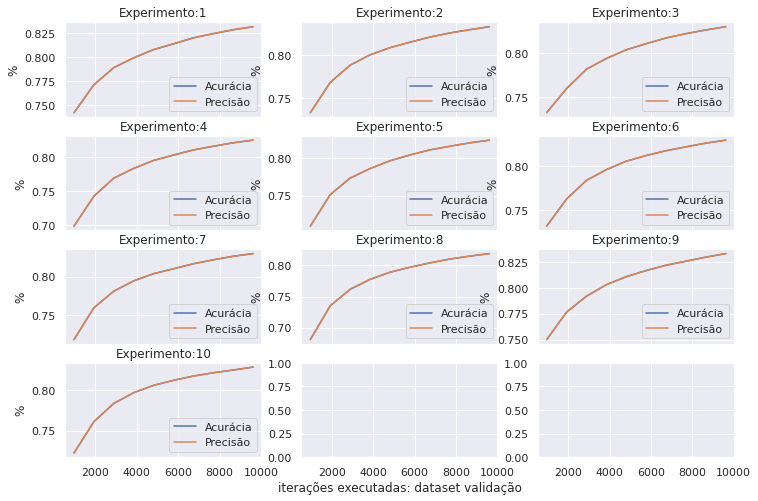

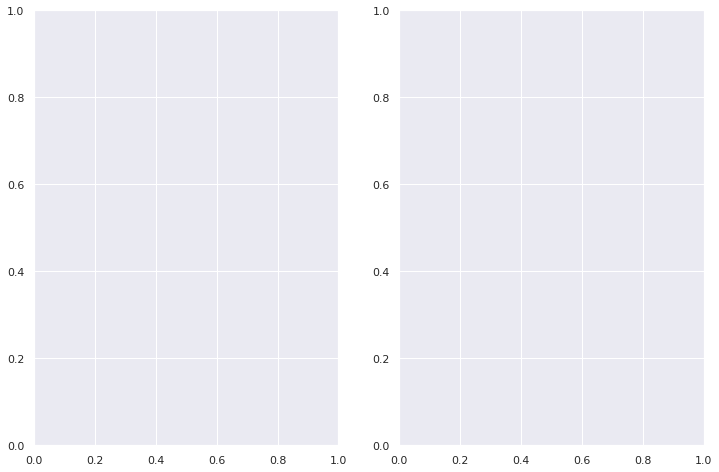

In [19]:
analisa_treinamento(id_planilha = 9) #max_seq_length=128


Model loaded from <== ./bertimbau_resp/9.1/0/metrics.pt
Model loaded from <== ./bertimbau_resp/9.1/1/metrics.pt
Model loaded from <== ./bertimbau_resp/9.1/2/metrics.pt
Model loaded from <== ./bertimbau_resp/9.1/3/metrics.pt
Model loaded from <== ./bertimbau_resp/9.1/4/metrics.pt
Model loaded from <== ./bertimbau_resp/9.1/5/metrics.pt
Model loaded from <== ./bertimbau_resp/9.1/6/metrics.pt
Model loaded from <== ./bertimbau_resp/9.1/7/metrics.pt
Model loaded from <== ./bertimbau_resp/9.1/8/metrics.pt
Model loaded from <== ./bertimbau_resp/9.1/9/metrics.pt


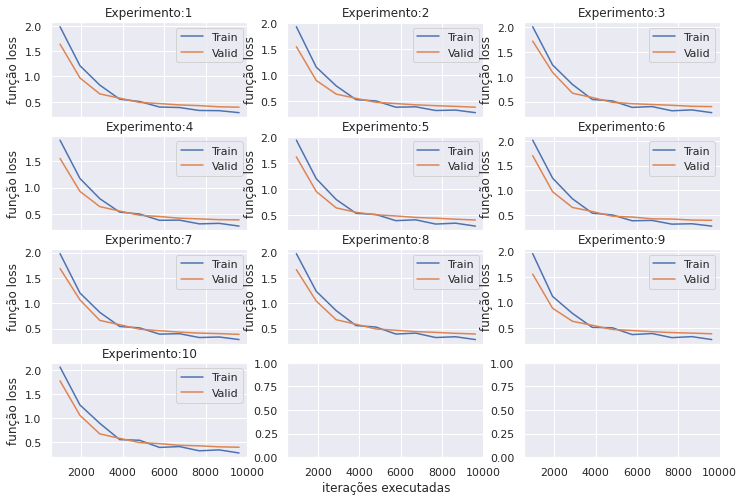

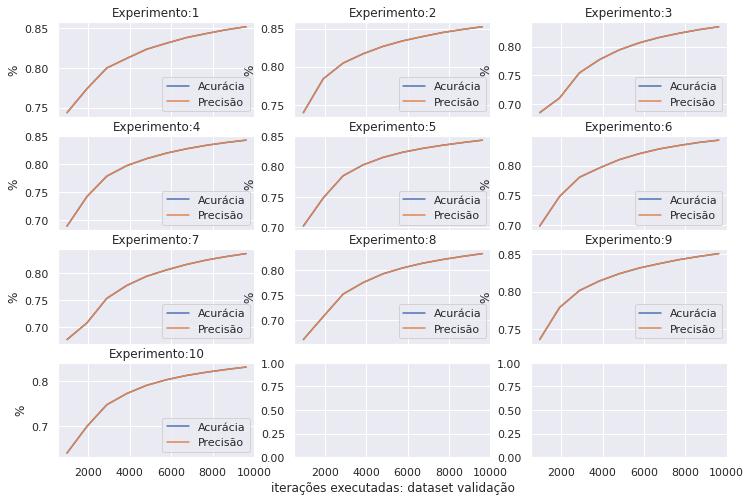

In [ ]:
analisa_treinamento(id_planilha = 9.1) #max_seq_length=256

Model loaded from <== ./bertimbau_resp/9.2/0/metrics.pt
Model loaded from <== ./bertimbau_resp/9.2/1/metrics.pt
Model loaded from <== ./bertimbau_resp/9.2/2/metrics.pt
Model loaded from <== ./bertimbau_resp/9.2/3/metrics.pt
Model loaded from <== ./bertimbau_resp/9.2/4/metrics.pt
Model loaded from <== ./bertimbau_resp/9.2/5/metrics.pt
Model loaded from <== ./bertimbau_resp/9.2/6/metrics.pt
Model loaded from <== ./bertimbau_resp/9.2/7/metrics.pt
Model loaded from <== ./bertimbau_resp/9.2/8/metrics.pt
Model loaded from <== ./bertimbau_resp/9.2/9/metrics.pt


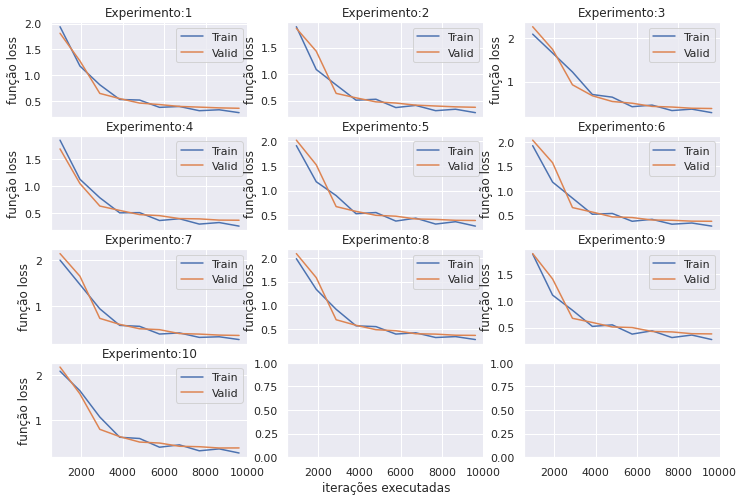

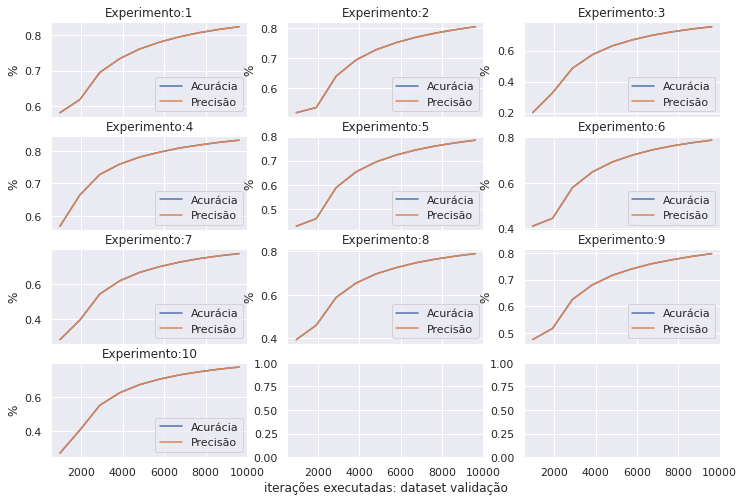

In [ ]:
analisa_treinamento(id_planilha = 9.2) #max_seq_length=512

In [ ]:
analisa_treinamento(id_planilha = '9.2/bs2/')
analisa_treinamento(id_planilha = '9.2/bs4/')
analisa_treinamento(id_planilha = '9.2/bs8/')

NameError: ignored

Model loaded from <== ./bertimbau_resp/9.4/0/metrics.pt
Model loaded from <== ./bertimbau_resp/9.4/1/metrics.pt
Model loaded from <== ./bertimbau_resp/9.4/2/metrics.pt
Model loaded from <== ./bertimbau_resp/9.4/3/metrics.pt
Model loaded from <== ./bertimbau_resp/9.4/4/metrics.pt
Model loaded from <== ./bertimbau_resp/9.4/5/metrics.pt
Model loaded from <== ./bertimbau_resp/9.4/6/metrics.pt
Model loaded from <== ./bertimbau_resp/9.4/7/metrics.pt
Model loaded from <== ./bertimbau_resp/9.4/8/metrics.pt
Model loaded from <== ./bertimbau_resp/9.4/9/metrics.pt


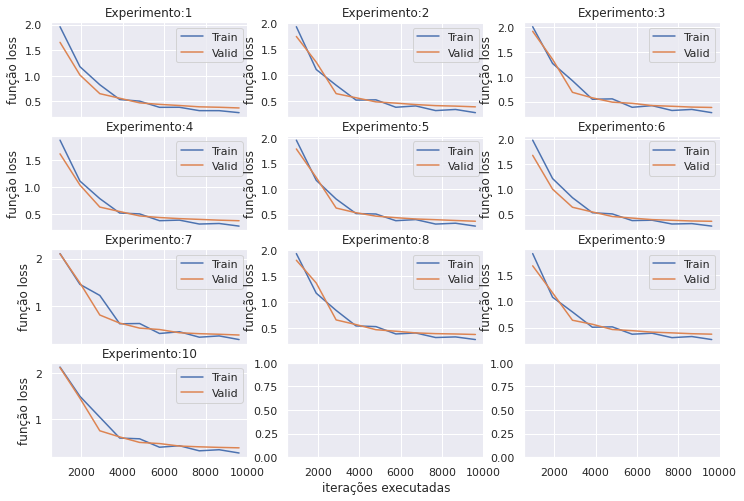

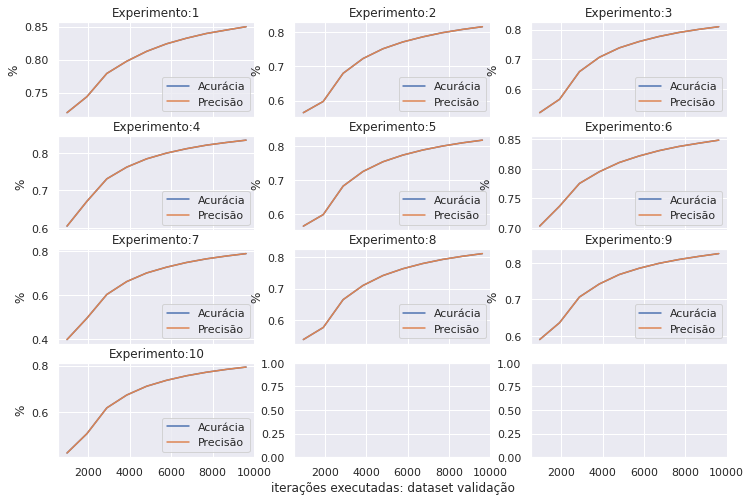

In [ ]:
analisa_treinamento(id_planilha = '9.4')

1  2  3  4  5  6  7  71  72  9	9.1  9.2  9.3  9.4  9.9  999


# AVALIANDO O MODELO

In [ ]:
def avalia_modelo(id_planilha):
  dataset = 5
  gerais=[]
  porclasse=[]
  X_saida = []
  y_hat = []
  file_path = processo.destination_folder + "/"+str(id_planilha)
  for idx  in range(10):
    seed= 420 + idx*10
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    file_path = processo.destination_folder + "/"+str(id_planilha)+'/'+str(idx)
    best_model = BERT(qtd_categories=processo.qtd_categorias).to(processo.device)
    processo.load_checkpoint(file_path + '/model.pt', best_model)
    tokens = processo.tokenizaAmostra(processo.source_folder+str(dataset),soTeste=True)
    X_saida_teste, y_true, y_pred = processo.evaluate(best_model, tokens[2]) #tokens[2] é o dataset de teste
    dctMetricas, dfPorClasse = processo.obtemMetricas(y_true,y_pred)    
    gerais.append(dctMetricas)
    porclasse.append(dfPorClasse)
    X_saida.append(X_saida_teste)
    y_hat.append(y_pred)
    del(best_model)
  return[gerais, porclasse, X_saida, y_hat]
  
def obtem_metrica_por_classe(porclasse):
  frame=[]
  for i, df in enumerate(porclasse):
    df['classe']= df.index.tolist()
    df['teste']=i
    frame.append(df)

  dfMetricas = pd.concat(frame, sort=False)
  frame=[]
  for classe in range(10):
    dfClasse = dfMetricas[dfMetricas['classe']==str(classe)]
    dfDesc = pd.DataFrame(dfClasse.describe().reset_index().drop(['support','teste'],axis=1).rename(columns={'index':'medida'}))
    dfDesc['classe']=classe
    frame.append(dfDesc)
  dfMedidas = pd.concat(frame, sort=False)
  dfMedidas = dfMedidas[(dfMedidas['medida']=='mean') | (dfMedidas['medida']=='std')] # (dfMedidas['medida']=='std')
  dfMedidas.sort_values(by=['medida','classe']).reset_index().drop('index',axis=1).T
  return dfMedidas

def obtem_metricas_gerais(gerais):
  frame=[]
  for i, dct in enumerate(gerais):
    df = pd.DataFrame.from_dict(dct, orient='index') #.reset_index().rename(columns={'index':'metrica'})
    df['experimento']=i
    frame.append(df)
  dfGerais = pd.concat(frame, sort=False).reset_index().rename(columns={'index':'medida',0:'valor'})
  frame=[]
  for medida in dfGerais['medida'].tolist():
    dftmp = dfGerais[dfGerais['medida']==medida].describe().reset_index().rename(columns={'index':'medida'})[['medida','valor']]
    dftmp['metrica'] = medida
    frame.append(dftmp[(dftmp['medida']=='mean') | (dftmp['medida']=='std')])
  return pd.concat(frame,sort=False)

def imprime_grafico_porclasse(dfMedidas, y):
  g = sns.catplot(x='medida', y=y, hue='classe', data=dfMedidas, kind='bar', height=8.0)
  g.fig.set_size_inches(15,8)
  g.fig.subplots_adjust(top=0.81,right=0.86)  
  g.fig.suptitle('Média e Desvio Padrão da ' + y +  ' para as 10 execuções de Tamanho de Sequência = ' +  str(processo.MAX_SEQ_LEN))

  ax = g.facet_axis(0,0)
  for p in ax.patches:
      ax.text(p.get_x() , 
              p.get_height() , 
            '{0:.2f}'.format(p.get_height()),  
              color='black', 
              rotation='horizontal', 
              )#size='large'

def imprime_grafico_MetricasGerais(dfMedidas):
  g = sns.catplot(x='medida', y='valor', hue='metrica', data=dfMedidas, kind='bar', height=8.0)
  g.fig.set_size_inches(15,8)
  g.fig.subplots_adjust(top=0.81,right=0.86)  
  g.fig.suptitle('Média e Desvio Padrão das métricas = ' +  str(processo.MAX_SEQ_LEN))

  ax = g.facet_axis(0,0)
  for p in ax.patches:
      ax.text(p.get_x() , 
              p.get_height() , 
            '{0:.2f}'.format(p.get_height()),  
              color='black', 
              rotation='horizontal', 
              size='large')

## PRECISÃO, RECALL, F1-SCORE PARA CADA CLASSE

In [ ]:
processo = BERTimbau_Noticias(tokenizer = tokenizer,
                              max_seq_length = 394,
                              bs=8,
                              lr=1e-06,
                              qtd_categorias=10)

gerais, porclasse, X_saida_teste, y_pred = avalia_modelo(id_planilha='9.4')
df_mean_std_porclasse = obtem_metrica_por_classe(porclasse)
df_mean_std_geral = obtem_metricas_gerais(gerais)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/0/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/1/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/2/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/3/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/4/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/5/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/6/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/7/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/8/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/9/model.pt


In [ ]:
df_mean_std_porclasse

,medida,precision,recall,f1-score,classe
1,mean,0.916348,0.904000,0.909992,0
2,std,0.019840,0.008097,0.009268,0
1,mean,0.878000,0.859296,0.867888,1
2,std,0.031418,0.024274,0.012514,1
1,mean,0.966529,0.995431,0.980752,2
2,std,0.006167,0.003746,0.003075,2
1,mean,0.911911,0.908057,0.909838,3
2,std,0.017738,0.009266,0.007559,3
1,mean,0.925196,0.937245,0.931058,4
2,std,0.011245,0.013402,0.004975,4


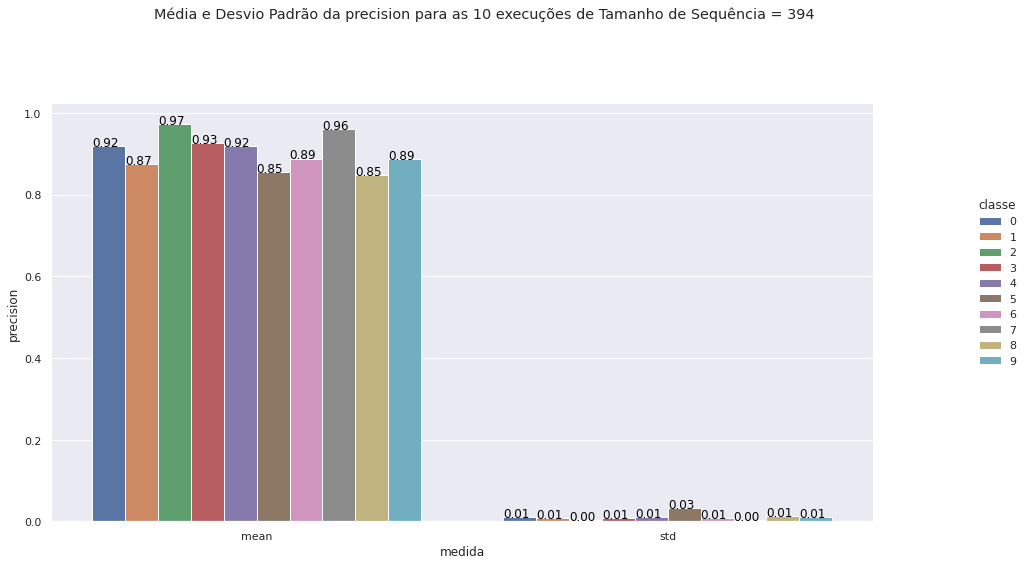

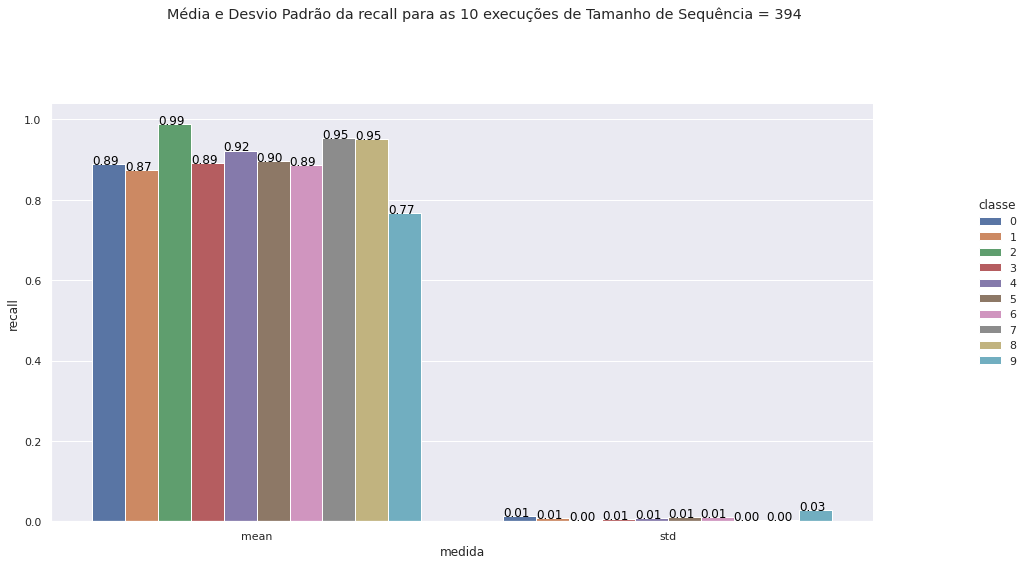

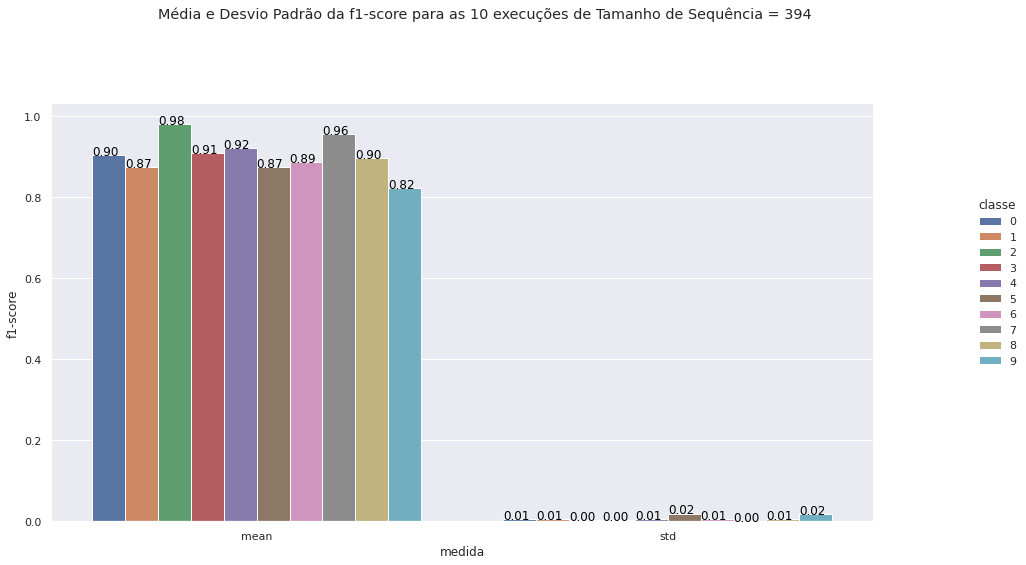

In [ ]:
imprime_grafico_porclasse(df_mean_std_porclasse, 'precision' )
imprime_grafico_porclasse(df_mean_std_porclasse, 'recall' )
imprime_grafico_porclasse(df_mean_std_porclasse, 'f1-score' )

## MÉTRICAS GERAIS: ACURÁCIA, ACURÁCIA BALANCEADA, COHEN KAPPA, PRECISÃO REVOCAÇÃO

In [ ]:
df_mean_std_geral

,medida,valor,metrica
1,mean,0.800519,acuraccy
2,std,0.036357,acuraccy
1,mean,0.801062,balanced_accuracy
2,std,0.035618,balanced_accuracy
1,mean,0.800519,precision_global
...,...,...,...
2,std,0.027508,f1score_local
1,mean,0.778200,cohen_kappa
2,std,0.040389,cohen_kappa
1,mean,0.786076,ccmatheus


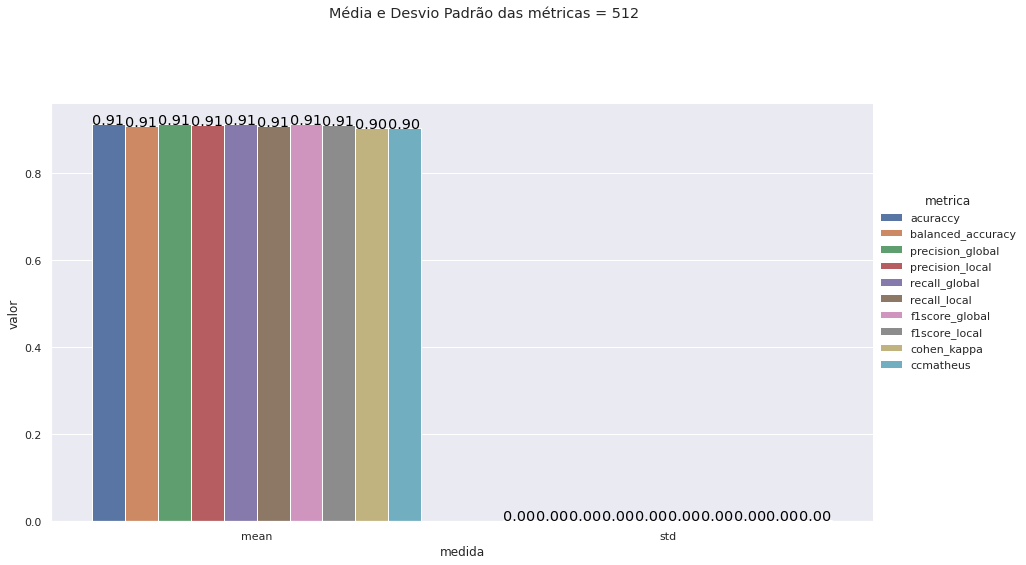

In [ ]:
imprime_grafico_MetricasGerais(df_mean_std_geral)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1925 samples in 0.003s...
[t-SNE] Computed neighbors for 1925 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1925
[t-SNE] Computed conditional probabilities for sample 1925 / 1925
[t-SNE] Mean sigma: 0.299890
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.547104
[t-SNE] KL divergence after 1000 iterations: 0.589578


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


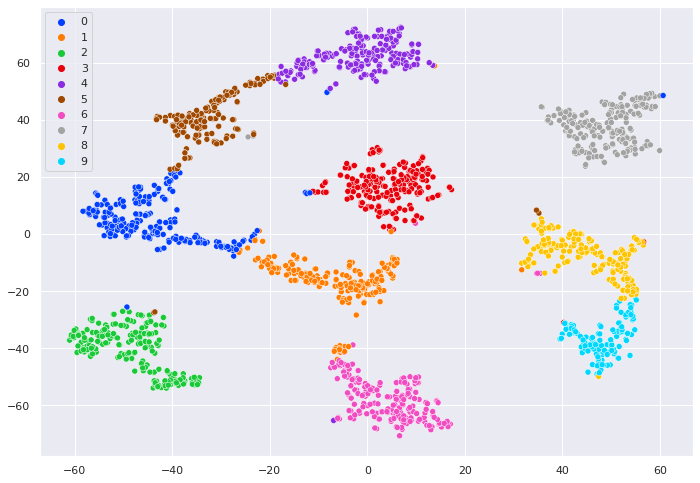

In [ ]:
processo.imprimeGraficosReducaoDimensaoTSNE(X_saida_teste, y_pred)